In [1]:
# 

# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
np.random.seed(42)

# Importing the dataset
df_train = pd.read_csv('resources/train.csv')
df_test = pd.read_csv('resources/test.csv')

In [2]:
df_train.head()

,Country,Year,Ladder,GDP,Support,Health,Freedom,Generosity,Corruption
0,Afghanistan,2008,3.723590,7.144916,0.450662,50.799999,0.718114,0.178993,0.881686
1,Afghanistan,2009,4.401778,7.314788,0.552308,51.200001,0.678896,0.201228,0.850035
2,Afghanistan,2010,4.758381,7.421525,0.539075,51.599998,0.600127,0.131578,0.706766
3,Afghanistan,2011,3.831719,7.394349,0.521104,51.919998,0.495901,0.173452,0.731109
4,Afghanistan,2012,3.782938,7.480296,0.520637,52.240002,0.530935,0.246943,0.775620


In [3]:
print("Train: ", df_train.shape)
print("Test: ", df_test.shape)

Train:  (1627, 9)
Test:  (153, 9)


In [4]:
# Setting up arrays of predictors and target
X_train = df_train.iloc[:, 3:].values
y_train = df_train.iloc[:, 2].values
X_test = df_test.iloc[:, 3:].values
y_test = df_test.iloc[:, 2].values

In [5]:
# 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
params = {
    'max_depth': (3, 4, 5, 6, 7, 8, 10, 12),
    'n_estimators': (10, 20, 30, 40, 50, 100, 200, 300, 500, 700)}#, 900, 1000)}
model = RandomForestRegressor(random_state=42)
grid = GridSearchCV(model, params, verbose=4, n_jobs=-1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:   40.7s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.8min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_j

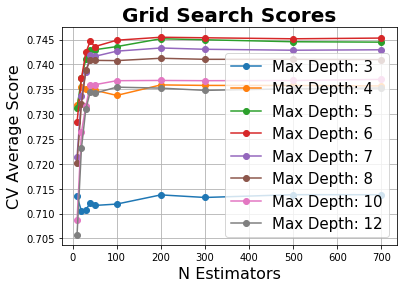

In [6]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')
    plt.savefig("grid_search_RFR.png", dpi=450)
    
plot_grid_search(grid.cv_results_, params['n_estimators'], params['max_depth'], 'N Estimators', 'Max Depth')

In [7]:
grid.best_score_

0.7454751915702902

In [8]:
grid.best_params_

{'max_depth': 6, 'n_estimators': 200}

In [9]:
regressor = RandomForestRegressor(**grid.best_params_, random_state=42)
#
#max_depth=6, n_estimators=200
regressor.fit(X_train, y_train)

In [10]:
print("Train: ", regressor.score(X_train, y_train))
print("Test: ", regressor.score(X_test, y_test))

Train:  0.8708959699076698
Test:  0.8341840094743651


In [11]:
feature_list = list(df_train.iloc[:, 3:].columns)
#Get numerical features importances
importances = list(regressor.feature_importances_)
#List of Tuples with vaiable and importances
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip (feature_list, importances)]
#Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
#Print out the feature and importances
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: Health               Importance: 0.7
Variable: GDP                  Importance: 0.12
Variable: Support              Importance: 0.09
Variable: Generosity           Importance: 0.04
Variable: Freedom              Importance: 0.03
Variable: Corruption           Importance: 0.02


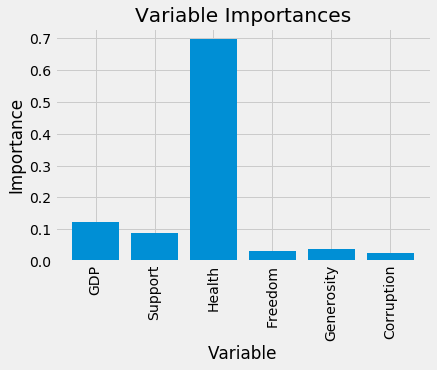

In [12]:
#Set the style
plt.style.use('fivethirtyeight')
#List of X locations for plotting
x_values= list(range(len(importances)))
#Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
#Tick labels for X axis
plt.xticks(x_values, feature_list, rotation = 'vertical')
#Axis labels and titles
plt.ylabel('Importance'); plt.xlabel('Variable');
plt.title('Variable Importances');

In [13]:
from sklearn.feature_selection import SelectFromModel
print("Feature Importance: ", regressor.feature_importances_)
model = SelectFromModel(regressor, prefit=True)
X_new = model.transform(X_train)
print("New Shape: ", X_new.shape)
X_new

Feature Importance:  [0.12195092 0.08682328 0.6982129  0.03032946 0.03806642 0.02461701]
New Shape:  (1627, 1)


array([[50.79999924],
       [51.20000076],
       [51.59999847],
       ...,
       [55.        ],
       [55.59999847],
       [56.20000076]])

In [15]:
regressor_new = RandomForestRegressor(max_depth=6, n_estimators=200, random_state=42)
#
#max_depth=6, n_estimators=200
regressor_new.fit(X_train[:, [0,1,2]], y_train);
print("Train: ", regressor_new.score(X_train[:, [0,1,2]], y_train))
print("Test: ", regressor_new.score(X_test[:, [0,1,2]], y_test))

Train:  0.8465045518484244
Test:  0.8205994331986658


In [16]:
# 
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
params = {
    'max_depth': (3, 4, 5, 6, 7, 8, 10, 12),
    'n_estimators': (10, 20, 30, 40, 50, 100, 200, 300, 500, 700)}#, 900, 1000)}
model = RandomForestRegressor(random_state=42)
grid = GridSearchCV(model, params, verbose=4, n_jobs=-1)
grid.fit(X_train[:, [0,1,2]], y_train)

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:   10.3s
[Parallel(n_jobs=-1)]: Done 205 tasks      | elapsed:   30.3s
[Parallel(n_jobs=-1)]: Done 376 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:  1.3min finished


GridSearchCV(cv=None, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=42,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_j

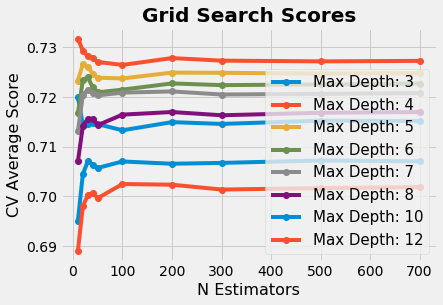

In [17]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')
    plt.savefig("grid_search_RFR_reduced.png", dpi=450)
    
plot_grid_search(grid.cv_results_, params['n_estimators'], params['max_depth'], 'N Estimators', 'Max Depth')

grid.best_score_

In [19]:
grid.best_params_

{'max_depth': 4, 'n_estimators': 10}

### Best Parameters from more elaborate grid search on better computer

In [4]:
from sklearn.ensemble import RandomForestRegressor
best = {'bootstrap': True,
 'max_depth': 8,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500}

regressor = RandomForestRegressor(**best, random_state=42)

regressor.fit(X_train, y_train)
print("Train: ", regressor.score(X_train, y_train))
print("Test: ", regressor.score(X_test, y_test))
print("Feature Importance: ", regressor.feature_importances_)

Train:  0.9107243400853815
Test:  0.8586766423688371


In [5]:
feature_list = list(df_train.iloc[:, 3:].columns)
#Get numerical features importances
importances = list(regressor.feature_importances_)
#List of Tuples with vaiable and importances
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip (feature_list, importances)]
#Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
#Print out the feature and importances
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: Health               Importance: 0.32
Variable: GDP                  Importance: 0.27
Variable: Support              Importance: 0.21
Variable: Freedom              Importance: 0.08
Variable: Corruption           Importance: 0.07
Variable: Generosity           Importance: 0.04


[None, None, None, None, None, None]

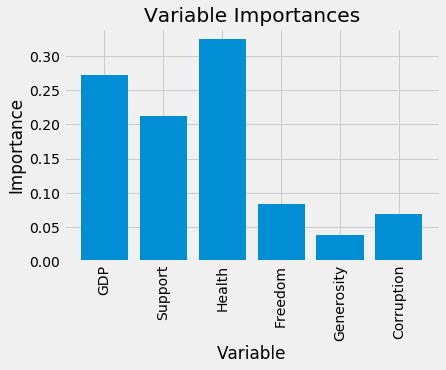

In [7]:
#Set the style
plt.style.use('fivethirtyeight')
#List of X locations for plotting
x_values= list(range(len(importances)))
#Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
#Tick labels for X axis
plt.xticks(x_values, feature_list, rotation = 'vertical')
#Axis labels and titles
plt.ylabel('Importance'); plt.xlabel('Variable')
plt.title('Variable Importances')
plt.savefig("variable_importance.png", dpi=400, bbox_inches='tight', pad_inches=0.3)

In [15]:
# Removing one feature and comparing R squared adjusted values
#For Potential feature importance
# and compare to above

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score

best = {'bootstrap': True,
 'max_depth': 8,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500}

feature_list = list(df_train.iloc[:, 3:].columns)
feature_list.insert(0, "None")

regressor = RandomForestRegressor(**best, random_state=42)

choose = [[0,1,2,3,4,5],[1,2,3,4,5],[0,2,3,4,5],[0,1,3,4,5],[0,1,2,4,5],[0,1,2,3,5],[0,1,2,3,4]]

n_train = len(y_train)
n_test = len(y_test)

R2_train = []
R2_test = []
R2_train_adj = []
R2_test_adj = []

for i in range(len(choose)):
    k = len(choose[i])
    regressor.fit(X_train[:, choose[i]], y_train)
    y_pred_train = regressor.predict(X_train[:, choose[i]])
    y_pred_test = regressor.predict(X_test[:, choose[i]])
    R2 = r2_score(y_train, y_pred_train)
    R2_adj = R2 - ((k - 1) / (n_train - k)) * (1 - R2)
    R2_train.append(R2)
    R2_train_adj.append(R2_adj)
    R2 = r2_score(y_test, y_pred_test)
    R2_adj = R2 - ((k - 1) / (n_test - k)) * (1 - R2)
    R2_test.append(R2)
    R2_test_adj.append(R2_adj)
    
    
col = ["Feature Removed", "R2 Train", "R2 Train Adjusted", "R2 Test", "R2 Test Adjusted", "Diff"]
diff = R2_test_adj[0] - R2_test_adj
var = [feature_list, R2_train, R2_train_adj, R2_test, R2_test_adj, diff]
df = pd.DataFrame()
for i in range(len(col)):
    if i > 0:
        df[col[i]] = [round(num, 3) for num in var[i]]
    else:
        df[col[i]] = var[i]
    
df

,Feature Removed,R2 Train,R2 Train Adjusted,R2 Test,R2 Test Adjusted,Diff
0,None,0.911,0.910,0.859,0.854,0.000
1,GDP,0.892,0.892,0.831,0.826,0.028
2,Support,0.898,0.897,0.841,0.837,0.017
3,Health,0.895,0.895,0.851,0.847,0.007
4,Freedom,0.906,0.905,0.853,0.849,0.005
5,Generosity,0.908,0.908,0.858,0.854,-0.000
6,Corruption,0.910,0.910,0.861,0.857,-0.003
